#Project description

The objective of this project is to apply four white-box evasion attacks against two deep learning classification models on the BelgiumTS (BTSC) dataset. In this project we used VGG16 and ResNet50 deep-learning classification models, and implemented Fast Gradient Sign Method (FGSM), Projected Gradient Descent (PGD), DeepFool attack, and Carlini & Wagner l2 (CW2) as non-targeted white-box evasion attacks against the above deep learning models.
We used Adversarial Robustness Toolbox (https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/attacks/evasion.html#carlini-and-wagner-l-2-attack) for DeepFool attack and CW2, and CleverHans (https://github.com/cleverhans-lab/cleverhans) for FGSM and PGD, using PyTorch (https://pytorch.org/tutorials/beginner/fgsm_tutorial.html) for the implementation of our models. First, we trained VGG16 and ResNet50 models on the BTSC dataset. Then, we applied four attacks to create non-targeted adversarial examples using the test set, by using five perturbation magnitudes( epsilons = [0, 5/255,  10/255, 20/255, 50/255]. In the third step, we created targeted white-box evasion attacks using FGSM, PGD, DeepFool, and CW2 attacks.
In this project we used Belgium traffic sign classification (BTSC)(https://btsd.ethz.ch/shareddata/) dataset which is a subset of the Belgium traffic sign dataset. This dataset involves 62 classes with 4591 and 2534 images in the training and the test sets respectively. Some of sample images from the BTSC dataset is shown in dataloader part.

#Setup

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
import torch
from torch import nn
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision
import torchvision.transforms
from torchvision.transforms import ToTensor
from torchvision.models import vgg16
from torchvision.models import resnet50
import torch.optim as optim

!pip install adversarial-robustness-toolbox
from art.attacks.evasion import DeepFool as DeepFool_
from art.attacks.evasion import CarliniL2Method
from art.estimators.classification import PyTorchClassifier
from tqdm import tqdm

from torch.utils.data import Dataset, DataLoader, Subset, random_split
from PIL import Image
from os import listdir
import natsort
from natsort import natsorted
from torchvision.io import read_image
from torchvision import transforms

In [ ]:
#FGSM & PGD
!pip install -qq -e git+http://github.com/tensorflow/cleverhans.git#egg=cleverhans
import sys
sys.path.append('/content/src/cleverhans')
import cleverhans

from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
from cleverhans.torch.attacks.projected_gradient_descent import projected_gradient_descent


In [ ]:
!pip install adversarial-robustness-toolbox
from art.attacks.evasion import DeepFool , SaliencyMapMethod, CarliniL2Method
from art.estimators.classification import PyTorchClassifier

#Data Loader

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

!wget https://btsd.ethz.ch/shareddata/BelgiumTSC/BelgiumTSC_Training.zip
!wget https://btsd.ethz.ch/shareddata/BelgiumTSC/BelgiumTSC_Testing.zip

--2021-12-16 00:34:41--  https://btsd.ethz.ch/shareddata/BelgiumTSC/BelgiumTSC_Training.zip
Resolving btsd.ethz.ch (btsd.ethz.ch)... 129.132.52.168, 2001:67c:10ec:36c2::168
Connecting to btsd.ethz.ch (btsd.ethz.ch)|129.132.52.168|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 174298785 (166M) [application/zip]
Saving to: ‘BelgiumTSC_Training.zip’

BelgiumTSC_Training 100%[===================>] 166.22M  8.18MB/s    in 32s     

2021-12-16 00:35:15 (5.12 MB/s) - ‘BelgiumTSC_Training.zip’ saved [174298785/174298785]

--2021-12-16 00:35:15--  https://btsd.ethz.ch/shareddata/BelgiumTSC/BelgiumTSC_Testing.zip
Resolving btsd.ethz.ch (btsd.ethz.ch)... 129.132.52.168, 2001:67c:10ec:36c2::168
Connecting to btsd.ethz.ch (btsd.ethz.ch)|129.132.52.168|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 77877833 (74M) [application/zip]
Saving to: ‘BelgiumTSC_Testing.zip’

BelgiumTSC_Testing. 100%[===================>]  74.27M  8.05MB/s    in 11s     


In [ ]:
!unzip 'BelgiumTSC_Training.zip'
!unzip 'BelgiumTSC_Testing.zip'

##Dataset Class

In [5]:
class BL_Dataset(Dataset):
    def __init__(self, Data, transform=None):
        if Data == "train":
            directory = 'Training/'
        elif Data == "test":
            directory = 'Testing/'

        folder_list = natsorted(listdir(directory))
        folder_list = folder_list[:-1]
        flist = []
        label_list = []
        for subfolder in folder_list:
          subfiles = natsorted(listdir(directory+subfolder))
          subfiles = subfiles[:-1]
          for subfile in subfiles:
            flist.append(directory+subfolder+'/'+subfile)
            label_list.append(int(subfolder))
        
        self.images = [Image.open(f) for f in flist]
        self.labels = torch.Tensor(label_list).long()

        self.transform = transform
    
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
         image = self.images[idx]
         label = self.labels[idx]
         if self.transform:
             image = self.transform(image)
         return image, label

In [7]:
dataset = BL_Dataset('train', transforms.Compose([transforms.ToTensor(),
                                                 transforms.Resize((32,32))
                                                 ]))
test_dataset = BL_Dataset('test', transforms.Compose([transforms.ToTensor(),
                                                      transforms.Resize((32,32))
                                                     ]))
train_dataset, validation_dataset = random_split(dataset, [round(.80*len(dataset)),
                                                           int(.20*len(dataset))])

In [32]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=64)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=64)
validation_dataloader = DataLoader(validation_dataset, shuffle=True, batch_size=64)

##Image samples

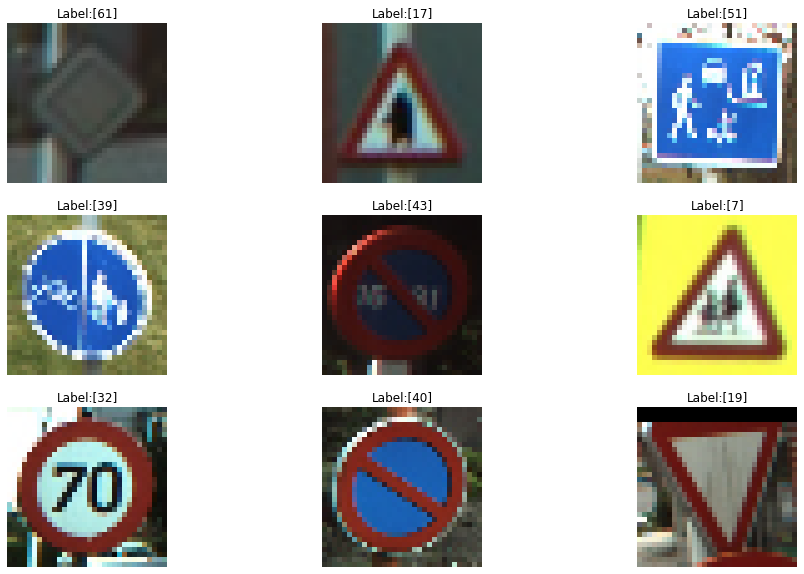

In [89]:
plt.figure(figsize=(16, 10))
data = iter(train_dataloader)
for n in range(9):
    ax = plt.subplot(3, 3, n+1)
    image, labels = next(data)
    img = image[0].permute(1, 2, 0).squeeze()
    plt.imshow(img.numpy())
    plt.title('Label:' + str([int(labels[0])]))
    plt.axis('off')
    

# Task 1: Train two deep-learning classification models on the BTSC dataset.

##1-VGG16

In [37]:
#VGG16
VGG16 = vgg16(pretrained=True)

In [38]:
VGG16.classifier._modules['6'] = nn.Linear(4096, 62)

In [39]:
VGG16.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

###Train

In [40]:
#Training
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(VGG16.parameters(), lr=0.001, momentum=0.9)

epoch_num = 10
training_loss_plot = []
training_accuracy_plot = []
val_loss_plot = []
val_accuracy_plot = []
for epoch in range(epoch_num):  # loop over the dataset multiple times

    running_loss = 0.0
    total = 0
    correct = 0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        
        inputs, labels = data
        labels = labels.type(torch.LongTensor)
        inputs, labels = inputs.cuda(), labels.cuda()

        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = VGG16(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if i % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
           
    training_loss_plot.append(running_loss)
    training_accuracy_plot.append(correct/total)

    #validation        
    running_loss = 0.0
    total = 0
    correct = 0
    with torch.no_grad():
      for i, data in enumerate(validation_dataloader, 0):
          # get the inputs; data is a list of [inputs, labels]
          
          inputs, labels = data
          labels = labels.type(torch.LongTensor)
          inputs, labels = inputs.cuda(), labels.cuda()
          
          # forward 
          outputs = VGG16(inputs)
          loss = criterion(outputs, labels)

          running_loss += loss.item()
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item() 
        
    val_loss_plot.append(running_loss)
    val_accuracy_plot.append(correct/total)
print('Finished Training')
print("validation ", val_accuracy_plot[epoch_num -1],"training", training_accuracy_plot[epoch_num-1])

Finished Training
validation  0.966120218579235 training 0.985792349726776


In [41]:
VGG16.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

###plot

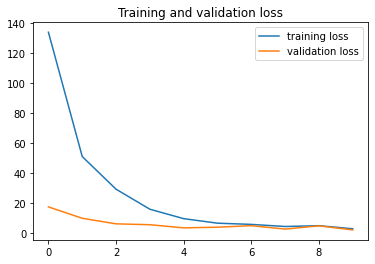

Text(0.5, 1.0, 'Training and validation accuracy')

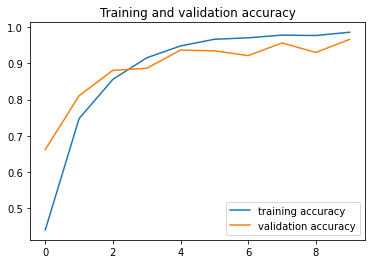

In [42]:
#VGG16 plot
plt.plot(training_loss_plot)
plt.plot(val_loss_plot)
plt.title('Training and validation loss')
plt.legend(['training loss', 'validation loss'])
plt.show()
plt.plot(training_accuracy_plot)
plt.legend(['training loss', 'validation loss'])
plt.plot(val_accuracy_plot)
plt.legend(['training accuracy', 'validation accuracy'])
plt.title('Training and validation accuracy')


###Test

In [43]:
#Test
correct = 0
total = 0
with torch.no_grad():
  for data in test_dataloader:
      images, labels = data
      labels = labels.type(torch.LongTensor)
      images = images.cuda()
      labels = labels.cuda()
      outputs = VGG16(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
print('Accuracy of the network on the test images: %f %%' % (
100 * correct / total))

Accuracy of the network on the test images: 92.619048 %


##2-ResNet50

In [44]:
#ResNet50
ResNet50 = torchvision.models.resnet50(pretrained = True) 

In [45]:
ResNet50._modules['6'] = nn.Linear(4096, 62)

###Train

In [46]:
#Training
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ResNet50.parameters(), lr=0.001) #, momentum=0.9)

epoch_num = 10
training_loss_plot = []
training_accuracy_plot = []
val_loss_plot = []
val_accuracy_plot = []
for epoch in range(epoch_num):  # loop over the dataset multiple times

    running_loss = 0.0
    total = 0
    correct = 0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        
        inputs, labels = data
        labels = labels.type(torch.LongTensor)
        inputs, labels = inputs.cuda(), labels.cuda()
        model = ResNet50

        if torch.cuda.is_available():
           model.cuda()

        optimizer.zero_grad()


        outputs = ResNet50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if i % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
           
    training_loss_plot.append(running_loss)
    training_accuracy_plot.append(correct/total)

    #validation        
    running_loss = 0.0
    total = 0
    correct = 0
    with torch.no_grad():
      for i, data in enumerate(validation_dataloader, 0):
          # get the inputs; data is a list of [inputs, labels]
          
          inputs, labels = data
          labels = labels.type(torch.LongTensor)
          inputs, labels = inputs.cuda(), labels.cuda()
          
          outputs = ResNet50(inputs)
          loss = criterion(outputs, labels)

          running_loss += loss.item()
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item() 
        
    val_loss_plot.append(running_loss)
    val_accuracy_plot.append(correct/total)
print('Finished Training')
print("validation ", val_accuracy_plot[epoch_num -1],"training", training_accuracy_plot[epoch_num-1])

Finished Training
validation  0.9672131147540983 training 0.9926229508196721


In [47]:
ResNet50.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

###Plot

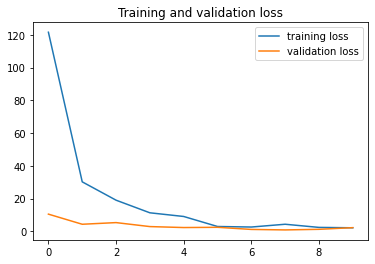

Text(0.5, 1.0, 'Training and validation accuracy')

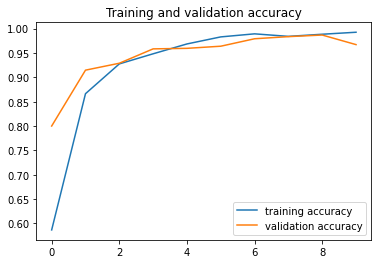

In [48]:
#ResNet50 plot
plt.plot(training_loss_plot)
plt.plot(val_loss_plot)
plt.title('Training and validation loss')
plt.legend(['training loss', 'validation loss'])
plt.show()
plt.plot(training_accuracy_plot)
plt.legend(['training loss', 'validation loss'])
plt.plot(val_accuracy_plot)
plt.legend(['training accuracy', 'validation accuracy'])
plt.title('Training and validation accuracy')


###Test

In [49]:
#Test
correct = 0
total = 0
with torch.no_grad():
  for data in test_dataloader:
      images, labels = data
      labels = labels.type(torch.LongTensor)
      images = images.cuda()
      labels = labels.cuda()
      outputs = ResNet50(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
print('Accuracy of the network on the test images: %f %%' % (
100 * correct / total))

Accuracy of the network on the test images: 96.071429 %


##3- Results and discussion:


#### Table 1: Classification accuracy of VGG16 and ResNet50 on the BTSC dataset

\begin{array}{|c|c|c|c|}
\hline
\textbf{Model} & \text{Train ACC(%)} & \text{Validation ACC(%)} & \text{Test ACC(%)} \\
\hline
\textbf{VGG16} & 98.57 & 96.61 & 92.61\\
\textbf{ResNet50} & 99.26 & 96.72 & 96.07 \\
\hline
\end{array}

The results show that the ResNet50 model had better performance in compare with the VGG16 model on the training, test, and validation set, on all sets all models attained more than 95% accuracy. In ResNet50 higher learning rate caused better performance, but in VGG16 lower learning rate worked better in our model.
In any case, the same learning rate of  0.001 ) was chosen for both networks in the final tests. It is likely that ResNet50 may perform better with higher learning rates than could be attained with VGG16.

#Task 2: non-targeted white-box evasion attacks against the deep learning models.

In task 2 we applied FSGM, PGD, DeepFool, and CW2 attacks to create non-targeted adversarial examples using the first 100 images of the test set.  The following perturbation magnitudes is applied for FGSM, PGD, and DeepFool in this test: epsilons = [0, 5/255,  10/255, 20/255, 50/255], and confidence values of 0.1, 0.5,and 1.0 is used for CW2 as the values of perturbation.



##1-VGG16

In [50]:
epsilons = [0, 5/255,  10/255, 20/255, 50/255]

###FSGM-VGG16

In [51]:
#FSGM- VGG16
correct = 0
total = 0
accuracies_FSGM =[]
sub_dataset = Subset(test_dataset, list(range(100)))
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)
for epsilon in epsilons:
  print(epsilon)
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    # labels = labels.type(torch.LongTensor)
    images = images.cuda()
    labels = labels.cuda()
    adversarial_images = fast_gradient_method(VGG16, images, epsilon, np.inf)
    outputs = VGG16(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    accuracy.append(correct/total)

  accuracies_FSGM.append(np.mean(accuracy))
print(accuracies_FSGM)
    


0
0.0196078431372549
0.0392156862745098
0.0784313725490196
0.19607843137254902
[0.62625, 0.5696341463414634, 0.45484848484848484, 0.36306318681318683, 0.3070172413793103]


###PGD-VGG16

In [52]:
#PGD-VGG16
correct = 0
total = 0
accuracies_PGD =[]
sub_dataset = Subset(test_dataset, list(range(100)))
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)

for epsilon in epsilons:
  print(epsilon)
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    # labels = labels.type(torch.LongTensor)
    images = images.cuda()
    labels = labels.cuda()
    adversarial_images = projected_gradient_descent(model_fn = VGG16, x =images, eps = epsilon, eps_iter =2.5*epsilon/60, nb_iter =60, norm = np.inf)
    outputs = VGG16(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    accuracy.append(correct/total)

  accuracies_PGD.append(np.mean(accuracy))
print(accuracies_PGD)

0
0.0196078431372549
0.0392156862745098
0.0784313725490196
0.19607843137254902
[0.62625, 0.45140243902439026, 0.3114393939393939, 0.24399725274725276, 0.19629310344827586]


###DeepFool-VGG16

In [35]:
#DeepFool

VGG16T = PyTorchClassifier(model=VGG16, loss=nn.CrossEntropyLoss(), nb_classes=62, input_shape=(3, 32, 32), device_type='gpu')
accuracies_DF = []
sub_dataset = Subset(test_dataset, list(range(100)))
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)

correct = 0
total = 0
correct_attack = 0
epsilons = [0, 5/255, 10/255, 20/255, 50/255]
for epsilon in tqdm(epsilons):
  print(epsilon)
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    labels = labels.cuda()
    adversarial_images = DeepFool(VGG16T, epsilon= epsilon, batch_size= 64, max_iter = 50).generate(images.numpy())
    adversarial_images = torch.tensor(adversarial_images).cuda()    
    outputs = VGG16(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    accuracy.append(correct/total)

  accuracies_DF.append(np.mean(accuracy))
print(accuracies_DF)


  0%|          | 0/5 [00:00<?, ?it/s]

0


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

 20%|██        | 1/5 [01:17<05:11, 77.98s/it]

0.0196078431372549


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

 40%|████      | 2/5 [02:35<03:54, 78.00s/it]

0.0392156862745098


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

 60%|██████    | 3/5 [03:53<02:35, 77.99s/it]

0.0784313725490196


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

 80%|████████  | 4/5 [05:11<01:17, 77.98s/it]

0.19607843137254902


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 5/5 [06:29<00:00, 77.98s/it]

[0.170625, 0.24451219512195121, 0.26196969696969696, 0.2697527472527472, 0.27415517241379306]


###CW2-VGG16

In [34]:
#CW2
VGG16T = PyTorchClassifier(model=VGG16, loss=nn.CrossEntropyLoss(), nb_classes=62, input_shape=(3, 32, 32), device_type='gpu')
accuracies_CW2 = []
sub_dataset = Subset(test_dataset, list(range(100)))
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)
kap = [0, 0.1, 0.5, 1.0]
correct = 0
total = 0
correct_attack = 0
for k in tqdm(kap) :
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    labels = labels.cuda()
    adversarial_images = CarliniL2Method(VGG16T, confidence = k, 
                                         learning_rate = 0.01,
                                         max_iter = 7,
                                         batch_size = 64).generate(images.numpy())
    adversarial_images = torch.tensor(adversarial_images).cuda()    
    outputs = VGG16(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    accuracy.append(correct/total)

  accuracies_CW2.append(np.mean(accuracy))
print(accuracies_CW2)


  0%|          | 0/4 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:56<02:49, 56.56s/it]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

 50%|█████     | 2/4 [01:53<01:53, 56.50s/it]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [02:48<00:56, 56.12s/it]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 4/4 [03:44<00:00, 56.07s/it]

[0.0, 0.0, 0.0, 0.0]


###VGG16-FSGM_PGD_DeepFool plot

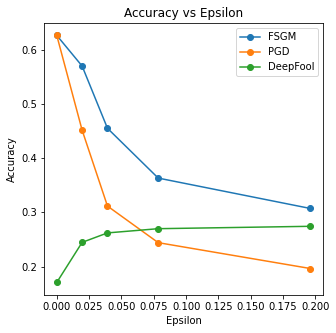

In [53]:
#VGG16-FSGM-PGD plot
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies_FSGM, "o-")
plt.plot(epsilons, accuracies_PGD, "o-")
plt.plot(epsilons, accuracies_DF, "o-")


plt.legend(['FSGM', 'PGD' , 'DeepFool'])
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()


###VGG16-CW2 plot

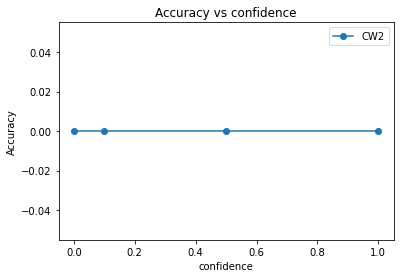

In [54]:
plt.plot(kap, accuracies_CW2, "o-")
plt.legend(['CW2'])
plt.title("Accuracy vs confidence")
plt.xlabel("confidence")
plt.ylabel("Accuracy")
plt.show()

###FSGM-VGG16 image plot

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  del sys.path[0]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


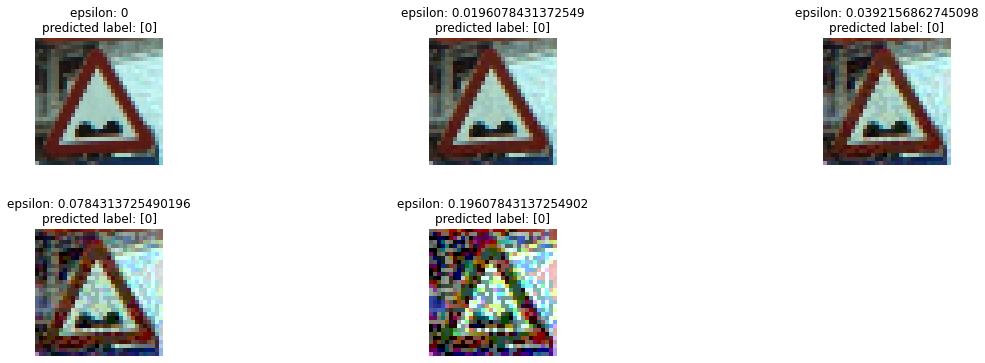

In [55]:
#FSGM- VGG16- image plot

sub_dataset = Subset(test_dataset, list(range(100)))
subsest_dataloader = DataLoader(sub_dataset, batch_size=1)
plt.figure(figsize=(20,15), constrained_layout=True)
cnt =1
left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.5   # the bottom of the subplots of the figure
top = 1.5    # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.5
plt.subplots_adjust(left, bottom, right, top, wspace, hspace)

for data in subsest_dataloader:
  for epsilon in epsilons: 
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    adversarial_images = fast_gradient_method(VGG16, images, epsilon, np.inf)
    outputs = VGG16(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    plt.subplot(6, 3, cnt)
    img = adversarial_images.cpu().detach().numpy()[0]
    img = np.transpose(img, [1,2,0])
    plt.imshow(img)
    label = predicted.cpu().detach().numpy()[0]
    plt.title('epsilon: '+ str(epsilon)+ '\n' + 'predicted label: ' + str([int(labels[0])]))
    
    plt.axis('off')
    cnt +=1
  break
    


##2- ResNet50

###FSGM-ResNet50

In [58]:
#FGSM- ResNet50
total = 0
correct = 0
accuracies =[]
sub_dataset = Subset(test_dataset, list(range(100)))
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)

for epsilon in epsilons:
  print(epsilon)
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    adversarial_images = fast_gradient_method(ResNet50, images, epsilon, np.inf)
    outputs = ResNet50(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    accuracy.append(correct/total)

  accuracies.append(np.mean(accuracy))
print(accuracies)


0
0.0196078431372549
0.0392156862745098
0.0784313725490196
0.19607843137254902
[0.84125, 0.7463414634146341, 0.63, 0.5116071428571428, 0.40720689655172415]


###PGD-ResNet50

In [59]:
#PGD- ResNet50
correct = 0
total = 0
accuracies =[]
sub_dataset = Subset(test_dataset, list(range(100)))
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)

for epsilon in epsilons:
  print(epsilon)
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    adversarial_images = projected_gradient_descent(model_fn = ResNet50, x =images, eps = epsilon, eps_iter =2.5*epsilon/60, nb_iter =60, norm = np.inf)
    outputs = ResNet50(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    accuracy.append(correct/total)

  accuracies.append(np.mean(accuracy))
print(accuracies)

0
0.0196078431372549
0.0392156862745098
0.0784313725490196
0.19607843137254902
[0.84125, 0.6955487804878049, 0.5020454545454545, 0.39479395604395606, 0.32302586206896555]


In [61]:
#DeepFool
accuracies_DF = []
ResNet50_RS = PyTorchClassifier(model=ResNet50, loss=nn.CrossEntropyLoss(), nb_classes=62, input_shape=(3, 32, 32), device_type='gpu')

sub_dataset = Subset(test_dataset, list(range(100)))
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)

correct = 0
total = 0
correct_attack = 0
for epsilon in tqdm(epsilons):
  print(epsilon)
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    labels = labels.cuda()
    adversarial_images = DeepFool(ResNet50_RS, epsilon= epsilon, batch_size = 64, max_iter = 50).generate(images.numpy())
    adversarial_images = torch.tensor(adversarial_images).cuda()    
    outputs = ResNet50(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    accuracy.append(correct/total)

  accuracies_DF.append(np.mean(accuracy))
print(accuracies_DF)


  0%|          | 0/5 [00:00<?, ?it/s]

0


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

 20%|██        | 1/5 [02:09<08:38, 129.50s/it]

0.0196078431372549


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

 40%|████      | 2/5 [03:37<05:16, 105.36s/it]

0.0392156862745098


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

 60%|██████    | 3/5 [05:47<03:52, 116.28s/it]

0.0784313725490196


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

 80%|████████  | 4/5 [07:56<02:01, 121.33s/it]

0.19607843137254902


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 5/5 [10:05<00:00, 121.09s/it]

[0.26625, 0.1720121951219512, 0.14242424242424243, 0.12855769230769232, 0.1205]


In [62]:
#CW2
accuracies_CW2 = []
sub_dataset = Subset(test_dataset, list(range(100)))
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)
kap = [0, 0.1, 0.5, 1.0]
correct = 0
total = 0
correct_attack = 0
for k in tqdm(kap):
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    labels = labels.cuda()
    adversarial_images = CarliniL2Method(ResNet50_RS, confidence = k, learning_rate = 0.001, max_iter = 7, batch_size = 64).generate(images.numpy())
    adversarial_images = torch.tensor(adversarial_images).cuda()    
    outputs = ResNet50(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    accuracy.append(correct/total)

  accuracies_CW2.append(np.mean(accuracy))
print(accuracies_CW2)


  0%|          | 0/4 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [01:13<03:41, 73.83s/it]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

 50%|█████     | 2/4 [02:27<02:27, 73.85s/it]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [03:41<01:13, 73.85s/it]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 4/4 [04:55<00:00, 73.84s/it]

[0.133125, 0.11097560975609756, 0.10325757575757576, 0.0996978021978022]


###DF-FSGM-PGD-ResNet50 plot

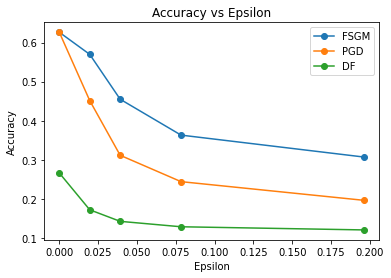

In [63]:

plt.plot(epsilons, accuracies_FSGM, "o-")
plt.plot(epsilons, accuracies_PGD, "o-")
plt.plot(epsilons, accuracies_DF, "o-")

plt.legend(['FSGM', 'PGD', 'DF'])
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()


###CW2-ResNet50 plot

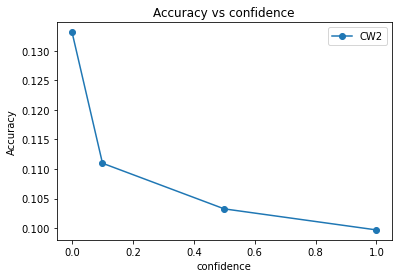

In [64]:
plt.plot(kap, accuracies_CW2, "o-")
plt.legend(['CW2'])
plt.title("Accuracy vs confidence")
plt.xlabel("confidence")
plt.ylabel("Accuracy")
plt.show()

###FSGM-ResNet50 image plot

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


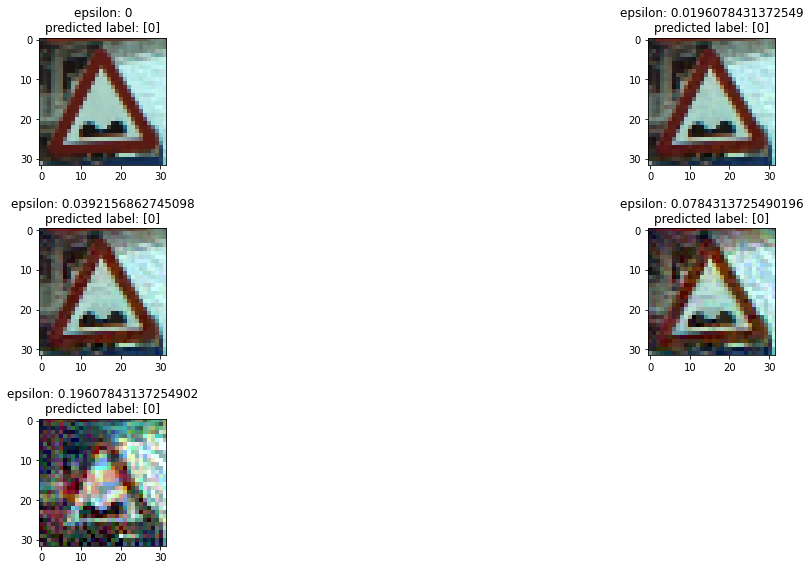

In [65]:
#FSGM- ResNet50- image plot
sub_dataset = Subset(test_dataset, list(range(100)))
subsest_dataloader = DataLoader(sub_dataset, batch_size=1)
plt.figure(figsize=(20,15))
cnt =1
left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.5   # the bottom of the subplots of the figure
top = 1.5    # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.5
plt.subplots_adjust(left, bottom, right, top, wspace, hspace)

for data in subsest_dataloader:
  for epsilon in epsilons: 
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    adversarial_images = projected_gradient_descent(model_fn = ResNet50, x =images, eps = epsilon, eps_iter =2.5*epsilon/60, nb_iter =60, norm = np.inf)
    outputs = ResNet50(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    plt.subplot(6, 2, cnt)
    img = adversarial_images.cpu().detach().numpy()[0]
    img = np.transpose(img, [1,2,0])
    plt.imshow(img)
    label = predicted.cpu().detach().numpy()[0]
    plt.title('epsilon: '+ str(epsilon)+ '\n' + 'predicted label: ' + str([int(labels[0])]))
    cnt +=1
  break
    


##3- Results and discussion:


 Table 2.1- Attack accuracy for FGSM, PGD, and DeepFool

\begin{array}{|c|c|c|c|c|}
\hline
\textbf{Model} & \text{Adversarial Images(%) $\epsilon = \frac{5}{255}$}
& \text{Adversarial Images(%) $\epsilon = \frac{10}{255}$} 
& \text{Adversarial Images(%) $\epsilon = \frac{20}{255}$} \\
\hline
\textbf{VGG16 - FGSM}  & 56.96\ & 45.48\ & 36.30\\\ 
\textbf{VGG16 - PGD}  & 45.14\ & 31.14\ & 24.39\\\
\textbf{VGG16 - DeepFool}  & 24.45\ & 26.19\ & 26.97\\\
\textbf{ResNet50 - FGSM}  & 74.63\ & 63\ & 51.16\\\
\textbf{ResNet50 - PGD}  & 69.55\ & 56.20\ & 36.47 \\
\textbf{ResNet50 - DeepFool}  & 17.20\ & 14.24\ & 12.85\\
\hline
\end{array}

On every test, DeepFool performs better than PGD and FGSM. Also, PGD has better performance in compare with FGSM.

 Table 2.2- Attack accuracy for CW2

\begin{array}{|c|c|c|c|c|}
\hline
\textbf{Model} & \text{Adversarial Images(%) $Confidence = 0.1$}
& \text{Adversarial Images(%) $Confidence = 0.5$} 
& \text{Adversarial Images(%) $Confidence = 1$} \\
\hline
\textbf{VGG16 - CW2}  & 0\ & 0\ & 0\\\
\textbf{ResNet50 - CW2}  & 11.09\ & 10.32\ & 9.96 \\
\hline
\end{array}

CW2 has the best performance among all attacks used in this test. 

# Task 3: Implement targeted white-box evasion attacks against the deep learning models.

In task 3 we implemented targeted white-box evasion attacks against the deep learning models.
In this test we used the images with Stop signs (label class 21) from the test set for this task. We applied four attacks on the Stop sign images to misclassify them as Speed Limit 70 sign images (target label class is 32).

##1- Targeted PGD

###VGG16

#### Accuracy on Label 21- Stop sign

In [91]:
#PGD-VGG16
total = 0
correct = 0
list1 = []
for i in range (len(test_dataset)):
  if test_dataset[i][1] == 21:
    list1.append(i)
accuracies_PGD =[]
sub_dataset = Subset(test_dataset, list1)
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)

for epsilon in epsilons:
  print(epsilon)
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    labels_f = torch.ones_like(labels).cuda()
    labels_f = labels_f.type(torch.LongTensor).cuda()
    adversarial_images = projected_gradient_descent(model_fn = VGG16, x =images,
                                                    eps = epsilon, eps_iter =2.5*epsilon/60, nb_iter =60, norm = np.inf, y = labels_f,  targeted = True )
    outputs = VGG16(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    accuracy.append(correct/total)

  accuracies_PGD.append(np.mean(accuracy))
print(accuracies_PGD)

0
0.0196078431372549
0.0392156862745098
0.0784313725490196
0.19607843137254902
[0.9333333333333333, 0.8888888888888888, 0.7333333333333333, 0.5944444444444444, 0.47555555555555556]


#### Accuracy on Label 32- speed limit

In [92]:
#PGD-VGG16
total = 0
correct = 0
list2 = []
for i in range (len(test_dataset)):
  if test_dataset[i][1] == 32:
    list2.append(i)
accuracies_PGD =[]
sub_dataset = Subset(test_dataset, list2)
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)

for epsilon in epsilons:
  print(epsilon)
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    labels_f = torch.ones_like(labels).cuda()
    labels_f = labels_f.type(torch.LongTensor).cuda()
    adversarial_images = projected_gradient_descent(model_fn = VGG16, x =images,
                                                    eps = epsilon, eps_iter =2.5*epsilon/60, nb_iter =60, norm = np.inf, y = labels_f,  targeted = True )
    outputs = VGG16(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels_f).sum().item()
    accuracy.append(correct/total)

  accuracies_PGD.append(np.mean(accuracy))
print(accuracies_PGD)

0
0.0196078431372549
0.0392156862745098
0.0784313725490196
0.19607843137254902
[0.0, 0.0, 0.001723459334058043, 0.023467385715041027, 0.06292178092714083]


####PGD- VGG16 image plot

0
0.0196078431372549


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0392156862745098


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0784313725490196


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.19607843137254902


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


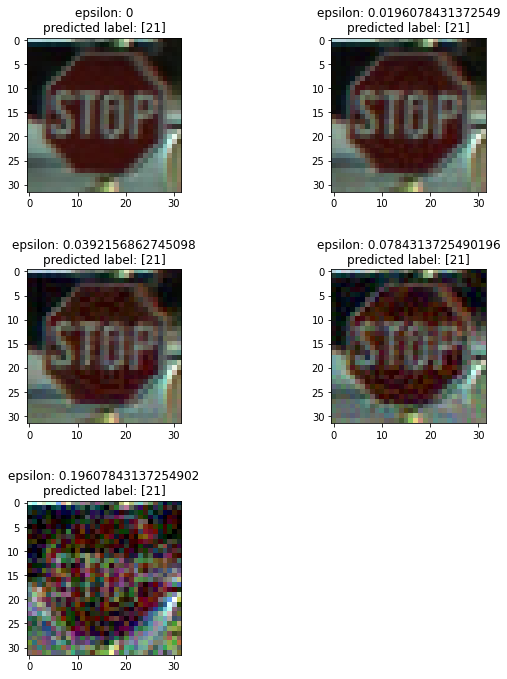

In [93]:
#PGD- VGG16- image plot
accuracies_PGD =[]
sub_dataset = Subset(test_dataset, list1)
subset_dataloader = DataLoader(sub_dataset, batch_size=1)

plt.figure(figsize=(10,15))
cnt =1
left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.5   # the bottom of the subplots of the figure
top = 1.5    # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.5
plt.subplots_adjust(left, bottom, right, top, wspace, hspace)

for epsilon in epsilons:
  print(epsilon)
  accuracy = []
  for data in subset_dataloader:
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    labels_f = torch.ones_like(labels).cuda()
    labels_f = labels_f.type(torch.LongTensor).cuda()
    adversarial_images = projected_gradient_descent(model_fn = VGG16, x =images, eps = epsilon, eps_iter =2.5*epsilon/60, nb_iter =60, norm = np.inf, y = labels_f,  targeted = True )
    outputs = VGG16(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    plt.subplot(5, 2, cnt)
    img = adversarial_images.cpu().detach().numpy()[0]
    img = np.transpose(img, [1,2,0])
    plt.imshow(img)
    label = predicted.cpu().detach().numpy()[0]
    plt.title('epsilon: '+ str(epsilon)+ '\n' + 'predicted label: ' + str([int(labels[0])]))
    cnt +=1
    break
  
    
    

### ResNet50

#### Accuracy on label 21

In [94]:
#ResNet50- PGD
total = 0
correct = 0
list4 = []
for i in range (len(test_dataset)):
  if test_dataset[i][1] == 21:
    list4.append(i)
accuracies_PGD =[]
sub_dataset = Subset(test_dataset, list4)
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)

for epsilon in epsilons:
  print(epsilon)
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    labels_f = torch.ones_like(labels).cuda()
    labels_f = labels_f.type(torch.LongTensor).cuda()
    adversarial_images = projected_gradient_descent(model_fn = ResNet50, x =images, eps = epsilon, eps_iter =2.5*epsilon/60, nb_iter =60, norm = np.inf, y = labels_f,  targeted = True )
    outputs = ResNet50(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    accuracy.append(correct/total)

  accuracies_PGD.append(np.mean(accuracy))
print(accuracies_PGD)

0
0.0196078431372549
0.0392156862745098
0.0784313725490196
0.19607843137254902
[0.9333333333333333, 0.8888888888888888, 0.7481481481481481, 0.5944444444444444, 0.48]


#### Accuracy on Label 32

In [95]:
#ResNet50- PGD
total = 0
correct = 0
list5 = []
for i in range (len(test_dataset)):
  if test_dataset[i][1] == 32:
    list5.append(i)
accuracies_PGD =[]
sub_dataset = Subset(test_dataset, list5)
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)

for epsilon in epsilons:
  print(epsilon)
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    labels_f = torch.ones_like(labels).cuda()
    labels_f = labels_f.type(torch.LongTensor).cuda()
    adversarial_images = projected_gradient_descent(model_fn = ResNet50, x =images, eps = epsilon, eps_iter =2.5*epsilon/60, nb_iter =60, norm = np.inf, y = labels_f,  targeted = True )
    outputs = ResNet50(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels_f).sum().item()
    accuracy.append(correct/total)

  accuracies_PGD.append(np.mean(accuracy))
print(accuracies_PGD)

0
0.0196078431372549
0.0392156862745098
0.0784313725490196
0.19607843137254902
[0.0, 0.000854290183138983, 0.04258031768613673, 0.1702087035267839, 0.3281916884250509]


####PGD- ResNet50 Image plot

0
0.0196078431372549


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0392156862745098


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0784313725490196


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.19607843137254902


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


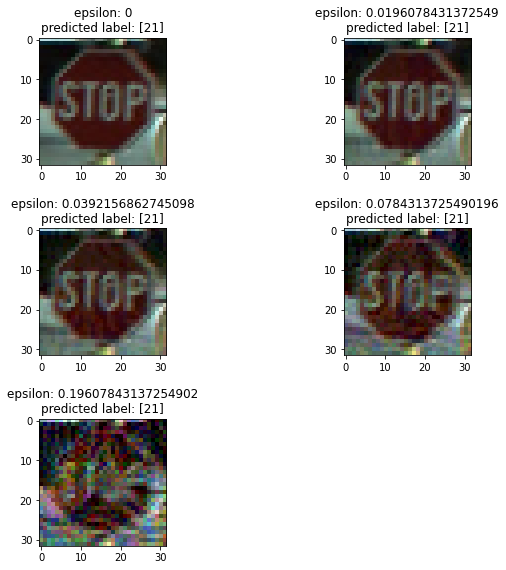

In [96]:
#ResNet50- PGD- Image plot
accuracies_PGD =[]
sub_dataset = Subset(test_dataset, list4)
subsest_dataloader = DataLoader(sub_dataset, batch_size=1)

plt.figure(figsize=(10,15))
cnt =1
left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.5   # the bottom of the subplots of the figure
top = 1.5    # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.5
plt.subplots_adjust(left, bottom, right, top, wspace, hspace)

for epsilon in epsilons:
  print(epsilon)
  accuracy = []
  # skip = True
  for data in subsest_dataloader:
    #if skip:
    #  skip = False
    #  continue
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    labels_f = torch.ones_like(labels).cuda()
    labels_f = labels_f.type(torch.LongTensor).cuda()
    adversarial_images = projected_gradient_descent(model_fn = ResNet50, x =images, eps = epsilon, eps_iter =2.5*epsilon/60, nb_iter =60, norm = np.inf, y = labels_f,  targeted = True )
    outputs = ResNet50(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    plt.subplot(6, 2, cnt)
    img = adversarial_images.cpu().detach().numpy()[0]
    img = np.transpose(img, [1,2,0])
    plt.imshow(img)
    label = predicted.cpu().detach().numpy()[0]
    plt.title('epsilon: '+ str(epsilon)+ '\n' + 'predicted label: ' + str([int(labels[0])]))
    cnt +=1
    break
    
    

##2- Targeted FGSM

### VGG16

#### Accuracy on label 21

In [102]:
#VGG16- FGSM
total = 0
correct = 0
list6 = []
for i in range (len(test_dataset)):
  if test_dataset[i][1] == 21:
    list6.append(i)
accuracies_FGSM =[]
sub_dataset = Subset(test_dataset, list6)
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)

for epsilon in epsilons:
  print(epsilon)
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    labels_f = torch.ones_like(labels).cuda()
    labels_f = labels_f.type(torch.LongTensor).cuda()
    adversarial_images = fast_gradient_method(model_fn = VGG16, x =images, eps = epsilon, norm = np.inf, y = labels_f,  targeted = True )
    outputs = VGG16(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    accuracy.append(correct/total)

  accuracies_FGSM.append(np.mean(accuracy))
print(accuracies_FGSM)

0
0.0196078431372549
0.0392156862745098
0.0784313725490196
0.19607843137254902
[0.9333333333333333, 0.9, 0.8814814814814815, 0.8166666666666667, 0.7333333333333333]


#### Accuracy on Label 32

In [103]:
#VGG16- FGSM
total = 0
correct = 0
list7 = []
for i in range (len(test_dataset)):
  if test_dataset[i][1] == 32:
    list7.append(i)
accuracies_FGSM =[]
sub_dataset = Subset(test_dataset, list7)
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)

for epsilon in epsilons:
  print(epsilon)
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    labels_f = torch.ones_like(labels).cuda()
    labels_f = labels_f.type(torch.LongTensor).cuda()
    adversarial_images = fast_gradient_method(model_fn = VGG16, x =images, eps = epsilon, norm = np.inf, y = labels_f,  targeted = True )
    outputs = VGG16(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels_f).sum().item()
    accuracy.append(correct/total)

  accuracies_FGSM.append(np.mean(accuracy))
print(accuracies_FGSM)

0
0.0196078431372549
0.0392156862745098
0.0784313725490196
0.19607843137254902
[0.0, 0.0, 0.0, 0.0, 0.0]


#### FGSM-VGG16 image plot

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
0.0196078431372549
0.0392156862745098
0.0784313725490196
0.19607843137254902


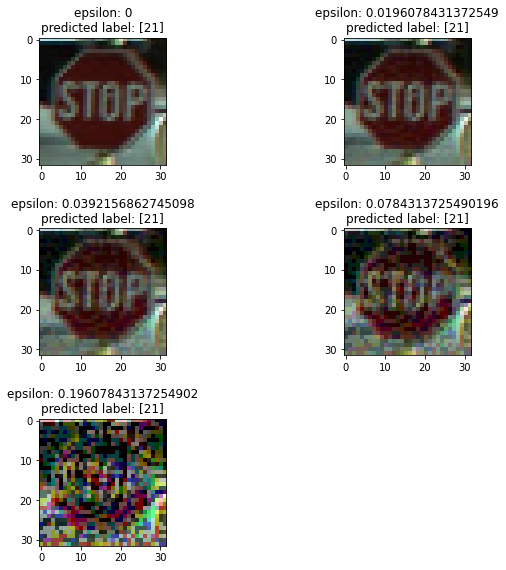

In [104]:
#VGG16- FGSM- Image plot
accuracies_FGSM =[]
sub_dataset = Subset(test_dataset, list6)
subsest_dataloader = DataLoader(sub_dataset, batch_size=1)

plt.figure(figsize=(10,15))
cnt =1
left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.5   # the bottom of the subplots of the figure
top = 1.5    # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.5
plt.subplots_adjust(left, bottom, right, top, wspace, hspace)

for epsilon in epsilons:
  print(epsilon)
  accuracy = []
  # skip = True
  for data in subsest_dataloader:
    #if skip:
    #  skip = False
    #  continue
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    labels_f = torch.ones_like(labels).cuda()
    labels_f = labels_f.type(torch.LongTensor).cuda()
    adversarial_images = fast_gradient_method(model_fn = VGG16, x =images, eps = epsilon, norm = np.inf, y = labels_f,  targeted = True )
    outputs = VGG16(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    plt.subplot(6, 2, cnt)
    img = adversarial_images.cpu().detach().numpy()[0]
    img = np.transpose(img, [1,2,0])
    plt.imshow(img)
    label = predicted.cpu().detach().numpy()[0]
    plt.title('epsilon: '+ str(epsilon)+ '\n' + 'predicted label: ' + str([int(labels[0])]))
    cnt +=1
    break
    
    

###ResNet50

####Accuracy on label 21

In [105]:
#ResNet50- FGSM
correct = 0
total = 0
list8 = []
for i in range (len(test_dataset)):
  if test_dataset[i][1] == 21:
    list8.append(i)
accuracies_FGSM =[]
sub_dataset = Subset(test_dataset, list8)
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)

for epsilon in epsilons:
  print(epsilon)
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    labels_f = torch.ones_like(labels).cuda()
    labels_f = labels_f.type(torch.LongTensor).cuda()
    adversarial_images = fast_gradient_method(model_fn = ResNet50, x =images, eps = epsilon, norm = np.inf, y = labels_f,  targeted = True )
    outputs = ResNet50(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    accuracy.append(correct/total)

  accuracies_FGSM.append(np.mean(accuracy))
print(accuracies_FGSM)

0
0.0196078431372549
0.0392156862745098
0.0784313725490196
0.19607843137254902
[0.9333333333333333, 0.8888888888888888, 0.8296296296296296, 0.7111111111111111, 0.5777777777777777]


####Accuracy on label 32

In [106]:
#ResNet50- FGSM
correct = 0
total = 0
list9 = []
for i in range (len(test_dataset)):
  if test_dataset[i][1] == 32:
    list9.append(i)
accuracies_FGSM =[]
sub_dataset = Subset(test_dataset, list9)
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)

for epsilon in epsilons:
  print(epsilon)
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    labels_f = torch.ones_like(labels).cuda()
    labels_f = labels_f.type(torch.LongTensor).cuda()
    adversarial_images = fast_gradient_method(model_fn = ResNet50, x =images, eps = epsilon, norm = np.inf, y = labels_f,  targeted = True )
    outputs = ResNet50(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels_f).sum().item()
    accuracy.append(correct/total)

  accuracies_FGSM.append(np.mean(accuracy))
print(accuracies_FGSM)

0
0.0196078431372549
0.0392156862745098
0.0784313725490196
0.19607843137254902
[0.9951488800496502, 0.890462305535065, 0.7011633848474614, 0.5280247256831043, 0.4124272715137251]


#### FSGM-ResNet50 image plot

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
0.0196078431372549
0.0392156862745098
0.0784313725490196
0.19607843137254902


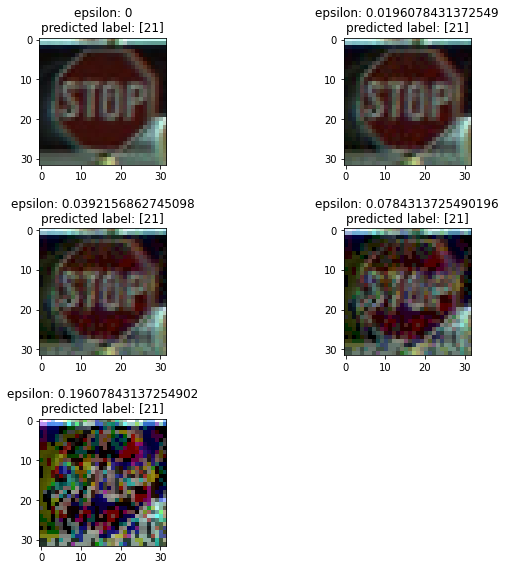

In [107]:
#ResNet50- FGSM- Image plot
#accuracies_FGSM =[]
sub_dataset = Subset(test_dataset, list8)
subsest_dataloader = DataLoader(sub_dataset, batch_size=1)

plt.figure(figsize=(10,15))
cnt =1
left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.5   # the bottom of the subplots of the figure
top = 1.5    # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.5
plt.subplots_adjust(left, bottom, right, top, wspace, hspace)

for epsilon in epsilons:
  print(epsilon)
  accuracy = []
  skip = True
  for data in subsest_dataloader:
    if skip:
      skip = False
      continue
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    labels_f = torch.ones_like(labels).cuda()
    labels_f = labels_f.type(torch.LongTensor).cuda()
    adversarial_images = fast_gradient_method(model_fn = ResNet50, x =images, eps = epsilon, norm = np.inf, y = labels_f,  targeted = True )
    outputs = ResNet50(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    plt.subplot(6, 2, cnt)
    img = adversarial_images.cpu().detach().numpy()[0]
    img = np.transpose(img, [1,2,0])
    plt.imshow(img)
    label = predicted.cpu().detach().numpy()[0]
    plt.title('epsilon: '+ str(epsilon)+ '\n' + 'predicted label: ' + str([int(labels[0])]))
    cnt +=1
    break
    
    

##Targeted DeepFool

###VGG16

####Acuuracy on label 21

In [109]:
#DF-VGG16
total = 0
correct = 0
list10 = []
for i in range (len(test_dataset)):
  if test_dataset[i][1] == 21:
    list10.append(i)
accuracies_DF =[]
sub_dataset = Subset(test_dataset, list10)
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)

for epsilon in tqdm (epsilons):
  print(epsilon)
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    labels = labels.cuda()
    labels_f = torch.ones_like(labels).cuda()
    labels_f = labels_f.type(torch.LongTensor).cuda()
    adversarial_images = DeepFool(VGG16T, epsilon= epsilon, batch_size= 64, max_iter = 50).generate(images.numpy())
    adversarial_images = torch.tensor(adversarial_images).cuda()    
    outputs = VGG16(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    accuracy.append(correct/total)

  accuracies_DF.append(np.mean(accuracy))
print(accuracies_DF)

  0%|          | 0/5 [00:00<?, ?it/s]

0


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:45<03:01, 45.43s/it]

0.0196078431372549


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

 40%|████      | 2/5 [01:30<02:16, 45.43s/it]

0.0392156862745098


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

 60%|██████    | 3/5 [02:16<01:30, 45.43s/it]

0.0784313725490196


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

 80%|████████  | 4/5 [03:01<00:45, 45.45s/it]

0.19607843137254902


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 5/5 [03:47<00:00, 45.45s/it]

[0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333]


####Accuracy on label 32

In [110]:
#DF-VGG16
total = 0
correct = 0
list11 = []
for i in range (len(test_dataset)):
  if test_dataset[i][1] == 32:
    list11.append(i)
accuracies_DF =[]
sub_dataset = Subset(test_dataset, list11)
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)

for epsilon in tqdm (epsilons):
  print(epsilon)
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    labels = labels.cuda()
    labels_f = torch.ones_like(labels).cuda()
    labels_f = labels_f.type(torch.LongTensor).cuda()
    adversarial_images = DeepFool(VGG16T, epsilon= epsilon, batch_size= 64, max_iter = 50).generate(images.numpy())
    adversarial_images = torch.tensor(adversarial_images).cuda()    
    outputs = VGG16(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels_f).sum().item()
    accuracy.append(correct/total)

  accuracies_DF.append(np.mean(accuracy))
print(accuracies_DF)

  0%|          | 0/5 [00:00<?, ?it/s]

0


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

 20%|██        | 1/5 [03:46<15:04, 226.19s/it]

0.0196078431372549


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

 40%|████      | 2/5 [07:32<11:18, 226.15s/it]

0.0392156862745098


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

 60%|██████    | 3/5 [11:18<07:32, 226.10s/it]

0.0784313725490196


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

 80%|████████  | 4/5 [15:04<03:46, 226.04s/it]

0.19607843137254902


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 5/5 [18:50<00:00, 226.05s/it]

[0.0, 0.0, 0.0, 0.0, 0.0]


#### DF-VGG16 image plot

  0%|          | 0/5 [00:00<?, ?it/s]

0


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:36<02:25, 36.27s/it]

0.0196078431372549


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

 40%|████      | 2/5 [01:12<01:48, 36.24s/it]

0.0392156862745098


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

 60%|██████    | 3/5 [01:48<01:12, 36.21s/it]

0.0784313725490196


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

 80%|████████  | 4/5 [02:24<00:36, 36.21s/it]

0.19607843137254902


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 5/5 [03:01<00:00, 36.21s/it]


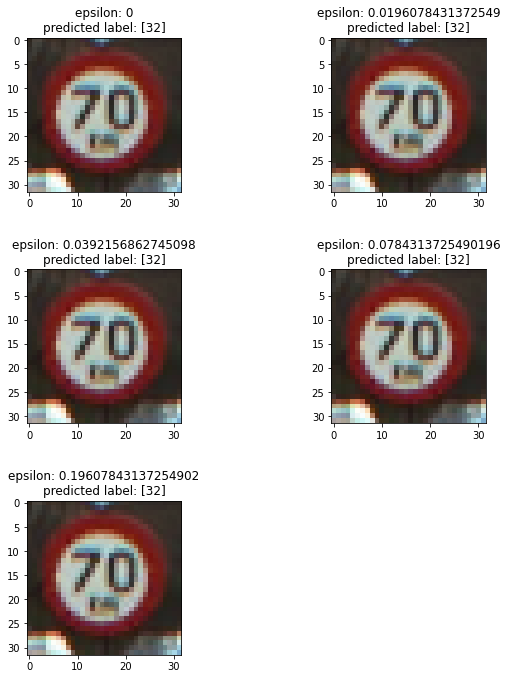

In [111]:
#DF- VGG16- image plot

sub_dataset = Subset(test_dataset, list10)
subset_dataloader = DataLoader(sub_dataset, batch_size=1)

plt.figure(figsize=(10,15))
cnt =1
left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.5   # the bottom of the subplots of the figure
top = 1.5    # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.5
plt.subplots_adjust(left, bottom, right, top, wspace, hspace)

for epsilon in tqdm (epsilons):
  print(epsilon)
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    labels = labels.cuda()
    labels_f = torch.ones_like(labels).cuda()
    labels_f = labels_f.type(torch.LongTensor).cuda()
    adversarial_images = DeepFool(VGG16T, epsilon= epsilon, batch_size= 64, max_iter = 50).generate(images.numpy())
    adversarial_images = torch.tensor(adversarial_images).cuda()    
    outputs = VGG16(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    plt.subplot(5, 2, cnt)
    img = adversarial_images.cpu().detach().numpy()[0]
    img = np.transpose(img, [1,2,0])
    plt.imshow(img)
    label = predicted.cpu().detach().numpy()[0]
    plt.title('epsilon: '+ str(epsilon)+ '\n' + 'predicted label: ' + str([int(labels[0])]))
    cnt +=1
    break
  
    
    

###ResNet50

####Accuracy on label 21

In [112]:
#DF-ResNet50
total = 0
correct = 0
list12 = []
for i in range (len(test_dataset)):
  if test_dataset[i][1] == 21:
    list12.append(i)
accuracies_DF =[]
sub_dataset = Subset(test_dataset, list12)
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)

for epsilon in tqdm (epsilons):
  print(epsilon)
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    labels = labels.cuda()
    labels_f = torch.ones_like(labels).cuda()
    labels_f = labels_f.type(torch.LongTensor).cuda()
    adversarial_images = DeepFool(ResNet50_RS, epsilon= epsilon, batch_size= 64, max_iter = 50).generate(images.numpy())
    adversarial_images = torch.tensor(adversarial_images).cuda()    
    outputs = ResNet50(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    accuracy.append(correct/total)

  accuracies_DF.append(np.mean(accuracy))
print(accuracies_DF)

  0%|          | 0/5 [00:00<?, ?it/s]

0


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:41<02:47, 41.97s/it]

0.0196078431372549


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

 40%|████      | 2/5 [01:23<02:05, 41.97s/it]

0.0392156862745098


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

 60%|██████    | 3/5 [02:05<01:23, 41.96s/it]

0.0784313725490196


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

 80%|████████  | 4/5 [02:47<00:41, 41.98s/it]

0.19607843137254902


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 5/5 [03:29<00:00, 41.97s/it]

[0.9555555555555556, 0.9555555555555556, 0.9555555555555556, 0.9555555555555556, 0.9555555555555556]


####Accuracy on label 32

In [114]:
#DF-ResNet50
total = 0
correct = 0
list13 = []
for i in range (len(test_dataset)):
  if test_dataset[i][1] == 32:
    list13.append(i)
accuracies_DF =[]
sub_dataset = Subset(test_dataset, list13)
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)

for epsilon in tqdm (epsilons):
  print(epsilon)
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    labels = labels.cuda()
    labels_f = torch.ones_like(labels).cuda()
    labels_f = labels_f.type(torch.LongTensor).cuda()
    adversarial_images = DeepFool(ResNet50_RS, epsilon= epsilon, batch_size= 64, max_iter = 50).generate(images.numpy())
    adversarial_images = torch.tensor(adversarial_images).cuda()    
    outputs = ResNet50(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels_f).sum().item()
    accuracy.append(correct/total)

  accuracies_DF.append(np.mean(accuracy))
print(accuracies_DF)

  0%|          | 0/5 [00:00<?, ?it/s]

0


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

 20%|██        | 1/5 [05:44<22:59, 344.98s/it]

0.0196078431372549


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

 40%|████      | 2/5 [11:29<17:14, 344.76s/it]

0.0392156862745098


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

 60%|██████    | 3/5 [17:14<11:29, 344.93s/it]

0.0784313725490196


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

 80%|████████  | 4/5 [22:59<05:44, 344.91s/it]

0.19607843137254902


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 5/5 [28:44<00:00, 344.83s/it]

[0.0, 0.0, 0.0, 0.0, 0.0]


#### DF-ResNet50 image plot

  0%|          | 0/5 [00:00<?, ?it/s]

0


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 20%|██        | 1/5 [00:43<02:52, 43.14s/it]

0.0196078431372549


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 40%|████      | 2/5 [01:26<02:09, 43.14s/it]

0.0392156862745098


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 60%|██████    | 3/5 [02:09<01:26, 43.14s/it]

0.0784313725490196


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 80%|████████  | 4/5 [02:52<00:43, 43.13s/it]

0.19607843137254902


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|██████████| 5/5 [03:35<00:00, 43.14s/it]


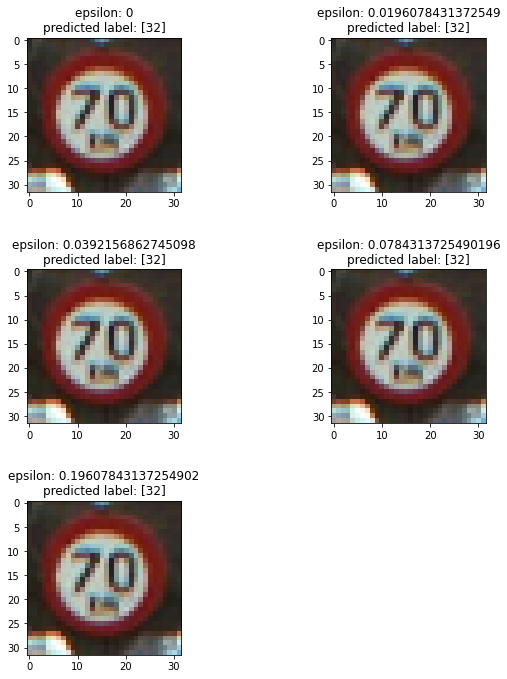

In [115]:
#DF- ResNet50- image plot

sub_dataset = Subset(test_dataset, list12)
subset_dataloader = DataLoader(sub_dataset, batch_size=64)

plt.figure(figsize=(10,15))
cnt =1
left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.5   # the bottom of the subplots of the figure
top = 1.5    # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.5
plt.subplots_adjust(left, bottom, right, top, wspace, hspace)

for epsilon in tqdm (epsilons):
  print(epsilon)
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    labels = labels.cuda()
    labels_f = torch.ones_like(labels).cuda()
    labels_f = labels_f.type(torch.LongTensor).cuda()
    adversarial_images = DeepFool(ResNet50_RS, epsilon= epsilon, batch_size= 64, max_iter = 50).generate(images.numpy())
    adversarial_images = torch.tensor(adversarial_images).cuda()    
    outputs = ResNet50(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    plt.subplot(5, 2, cnt)
    img = adversarial_images.cpu().detach().numpy()[0]
    img = np.transpose(img, [1,2,0])
    plt.imshow(img)
    label = predicted.cpu().detach().numpy()[0]
    plt.title('epsilon: '+ str(epsilon)+ '\n' + 'predicted label: ' + str([int(labels[0])]))
    cnt +=1
    break
  
    
    

##Targeted CW2

###VGG16

####Accuracy for label 21






In [121]:
#CW2-VGG16
total = 0
correct = 0
list14 = []
for i in range (len(test_dataset)):
  if test_dataset[i][1] == 21:
    list14.append(i)
accuracies_CW2 =[]
sub_dataset = Subset(test_dataset, list14)
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)
kap = [0, 0.1, 0.5, 1.0]
for k in tqdm (kap):
  
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    labels = labels.cuda()
    labels_f = torch.ones_like(labels).cuda()
    labels_f = labels_f.type(torch.LongTensor).cuda()
    adversarial_images = CarliniL2Method(VGG16T, confidence = k, 
                                         learning_rate = 0.01,
                                         max_iter = 7,
                                         batch_size = 64).generate(images.numpy())
    adversarial_images = torch.tensor(adversarial_images).cuda()    
    outputs = VGG16(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    accuracy.append(correct/total)

  accuracies_CW2.append(np.mean(accuracy))
print(accuracies_CW2)

  0%|          | 0/4 [00:00<?, ?it/s]

0


C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:21<01:03, 21.26s/it]

0


C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:42<00:42, 21.23s/it]

0


C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [01:03<00:21, 21.23s/it]

0


C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 4/4 [01:24<00:00, 21.20s/it]

[0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 0.8833333333333333]


####Accuracy for label 32

In [123]:
#CW2-VGG16
total = 0
correct = 0
list15 = []
for i in range (len(test_dataset)):
  if test_dataset[i][1] == 32:
    list15.append(i)
accuracies_CW2 =[]
sub_dataset = Subset(test_dataset, list15)
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)
kap = [0, 0.1, 0.5, 1.0]

for k in tqdm (kap):
  
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    labels = labels.cuda()
    labels_f = torch.ones_like(labels).cuda()
    labels_f = labels_f.type(torch.LongTensor).cuda()
    adversarial_images = CarliniL2Method(VGG16T, confidence = k, 
                                         learning_rate = 0.01,
                                         max_iter = 7,
                                         batch_size = 64).generate(images.numpy())
    adversarial_images = torch.tensor(adversarial_images).cuda()    
    outputs = VGG16(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels_f).sum().item()
    accuracy.append(correct/total)

  accuracies_CW2.append(np.mean(accuracy))
print(accuracies_CW2)

  0%|          | 0/4 [00:00<?, ?it/s]

0.0784313725490196


C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [02:14<06:43, 134.60s/it]

0.0784313725490196


C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

 50%|█████     | 2/4 [04:29<04:29, 134.72s/it]

0.0784313725490196


C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [06:44<02:14, 134.83s/it]

0.0784313725490196


C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 4/4 [08:59<00:00, 134.86s/it]

[0.0, 0.0, 0.0, 0.0]


#### CW2-VGG16 image plot

  0%|          | 0/4 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:22<01:06, 22.05s/it]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:44<00:44, 22.17s/it]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [01:06<00:22, 22.27s/it]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 4/4 [01:29<00:00, 22.37s/it]


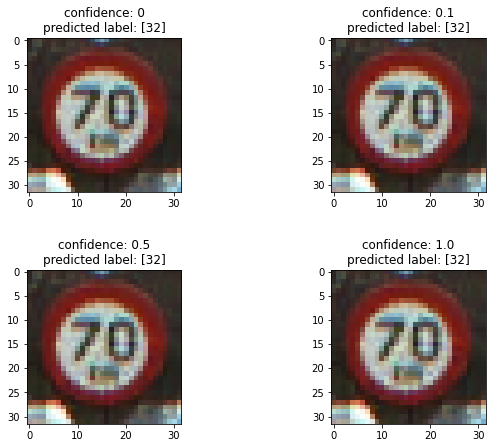

In [129]:
#CW2- VGG16- image plot

sub_dataset = Subset(test_dataset, list14)
subset_dataloader = DataLoader(sub_dataset, batch_size=64)

plt.figure(figsize=(10,15))
cnt =1
left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.5   # the bottom of the subplots of the figure
top = 1.5    # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.5
plt.subplots_adjust(left, bottom, right, top, wspace, hspace)
kap = [0, 0.1, 0.5, 1.0]

for k in tqdm (kap):
 
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    labels = labels.cuda()
    labels_f = torch.ones_like(labels).cuda()
    labels_f = labels_f.type(torch.LongTensor).cuda()
    adversarial_images = CarliniL2Method(VGG16T, confidence = k, 
                                         learning_rate = 0.01,
                                         max_iter = 7,
                                         batch_size = 64).generate(images.numpy())
    adversarial_images = torch.tensor(adversarial_images).cuda()    
    outputs = VGG16(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    plt.subplot(5, 2, cnt)
    img = adversarial_images.cpu().detach().numpy()[0]
    img = np.transpose(img, [1,2,0])
    plt.imshow(img)
    label = predicted.cpu().detach().numpy()[0]
    plt.title('confidence: '+ str(k)+ '\n' + 'predicted label: ' + str([int(labels[0])]))
    cnt +=1
    break
  
    
    

###ResNet50

####Accuracy for label21

In [125]:
#CW2-ResNet50
total = 0
correct = 0
list16 = []
for i in range (len(test_dataset)):
  if test_dataset[i][1] == 21:
    list16.append(i)
accuracies_CW2 =[]
sub_dataset = Subset(test_dataset, list16)
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)
kap = [0, 0.1, 0.5, 1.0]

for k in tqdm (kap):
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    labels = labels.cuda()
    labels_f = torch.ones_like(labels).cuda()
    labels_f = labels_f.type(torch.LongTensor).cuda()
    adversarial_images = CarliniL2Method(ResNet50_RS, confidence = k, learning_rate = 0.001, max_iter = 7, batch_size = 64).generate(images.numpy())
    adversarial_images = torch.tensor(adversarial_images).cuda()    
    outputs = ResNet50(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    accuracy.append(correct/total)

  accuracies_CW2.append(np.mean(accuracy))
print(accuracies_CW2)

  0%|          | 0/4 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:27<01:22, 27.35s/it]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:54<00:54, 27.32s/it]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [01:21<00:27, 27.27s/it]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 4/4 [01:49<00:00, 27.34s/it]

[0.06666666666666667, 0.06666666666666667, 0.05925925925925926, 0.05555555555555555]


####Accuracy for label 32

In [126]:
#CW2-ResNet50
total = 0
correct = 0
list17 = []
for i in range (len(test_dataset)):
  if test_dataset[i][1] == 32:
    list17.append(i)
accuracies_CW2 =[]
sub_dataset = Subset(test_dataset, list17)
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)

for k in tqdm (kap):
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    labels = labels.cuda()
    labels_f = torch.ones_like(labels).cuda()
    labels_f = labels_f.type(torch.LongTensor).cuda()
    adversarial_images = CarliniL2Method(ResNet50_RS, confidence = k, learning_rate = 0.001, max_iter = 7, batch_size = 64).generate(images.numpy())
    adversarial_images = torch.tensor(adversarial_images).cuda()    
    outputs = ResNet50(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels_f).sum().item()
    accuracy.append(correct/total)

  accuracies_CW2.append(np.mean(accuracy))
print(accuracies_CW2)

  0%|          | 0/4 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [02:57<08:52, 177.54s/it]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

 50%|█████     | 2/4 [05:55<05:55, 177.84s/it]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [08:53<02:57, 177.90s/it]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 4/4 [11:51<00:00, 177.91s/it]

[0.0, 0.0, 0.0, 0.0]


#### CW2-ResNet50 image plot

  0%|          | 0/4 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:23<01:10, 23.36s/it]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:46<00:46, 23.35s/it]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [01:09<00:23, 23.31s/it]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 4/4 [01:33<00:00, 23.31s/it]


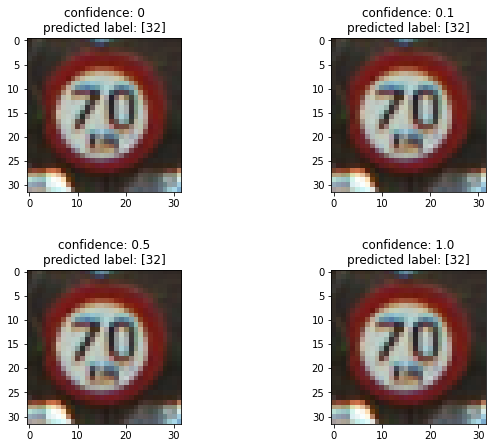

In [130]:
#CW2- ResNet50- image plot

sub_dataset = Subset(test_dataset, list16)
subset_dataloader = DataLoader(sub_dataset, batch_size=64)

plt.figure(figsize=(10,15))
cnt =1
left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.5   # the bottom of the subplots of the figure
top = 1.5    # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.5
plt.subplots_adjust(left, bottom, right, top, wspace, hspace)

for k in tqdm (kap):
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    labels = labels.cuda()
    labels_f = torch.ones_like(labels).cuda()
    labels_f = labels_f.type(torch.LongTensor).cuda()
    adversarial_images = CarliniL2Method(ResNet50_RS, confidence = k, learning_rate = 0.001, max_iter = 7, batch_size = 64).generate(images.numpy())
    adversarial_images = torch.tensor(adversarial_images).cuda()    
    outputs = ResNet50(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    plt.subplot(5, 2, cnt)
    img = adversarial_images.cpu().detach().numpy()[0]
    img = np.transpose(img, [1,2,0])
    plt.imshow(img)
    label = predicted.cpu().detach().numpy()[0]
    plt.title('confidence: '+ str(k)+ '\n' + 'predicted label: ' + str([int(labels[0])]))
    cnt +=1
    break
  
    
    

##3- Results and discussion:

Table 3
Accuracies on adversarial targeted PGD attack on Stop Sign Image (label 21) and Speed Limit 70 Sign Images (label 32) on VGG16


\begin{array}{|c|c|c|}
\hline
\textbf{Perturbation Level} & \text{PGD Attack - Stop Sign Images(%)} & \text{PGD Attack - Speed Limit 70 Sign Images(%)} \\
\hline
\epsilon = \frac{5}{255} & 88.88\ & 0\ \\
\epsilon = \frac{10}{255} & 73.33\ & 0.17\ \\
\epsilon = \frac{20}{255} & 59.44\ & 2.34\ \\
\epsilon = \frac{50}{255} & 47.55\ & 6.29\ \\
\hline
\end{array}